In [ ]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets

from torchsummary import summary

import time

tic = time.time()

num_epochs = 10
num_classes = 10
learning_rate = 0.01

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                          shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            #nn.Dropout(p=0.1),
            nn.Linear(14 * 14 * 16, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.1),
            nn.Linear(16, 10)
        )

    def forward(self, x):

        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)

        return x

def test_model(model):
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
  return (correct / total)

model = CNN()

summary(model,(1,28,28)) ## Prints the structure of the CNN model
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
per_epoch_loss_list = []
per_epoch_acc_list = []
test_per_epoch_acc_list = []

for epoch in range(num_epochs):
    epoch_no_correct=0
    epoch_total=0
    epoch_loss=0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        epoch_no_correct +=correct
        epoch_total +=total
        epoch_loss += loss.item()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
        
    per_epoch_loss_list.append(epoch_loss/len(train_loader))
    per_epoch_acc_list.append(epoch_no_correct/epoch_total)

    test_acc_per_epoch = test_model(model)
    test_per_epoch_acc_list.append(test_acc_per_epoch)


toc = time.time()

print('duration = ', toc - tic)
print(per_epoch_loss_list)
print(per_epoch_acc_list)
print(test_per_epoch_acc_list)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         LeakyReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         LeakyReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Linear-8                   [-1, 32]         100,384
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 16]             528
             ReLU-11                   [-1, 16]               0
           Linear-12                   [-1, 10]             170
Total params: 103,626
Trainable params: 103,626
Non-trainable params: 0
-------------------------------

Text(0.5, 1.0, 'YO (40241188) MS (40323793) HM(40242080) (AI_Bots)\nBatch Size = 1 ')

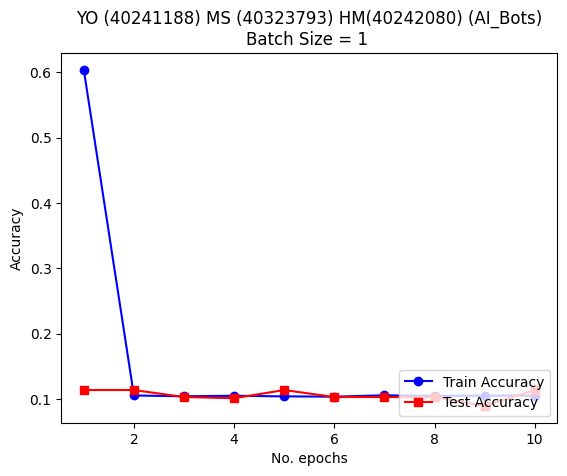

In [ ]:
## The batch size was changed manually for values of 1, 32, 64, and 256
import matplotlib.pyplot as plt
import numpy as np
plt.plot(range(1,num_epochs+1),per_epoch_acc_list, color='blue', marker='o') 
plt.plot(range(1,num_epochs+1),test_per_epoch_acc_list,  color='red', marker='s') 
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.xlabel('No. epochs')
plt.ylabel('Accuracy')
plt.title('YO (40241188) MS (40323793) HM(40242080) (AI_Bots)\nBatch Size = 1 ')

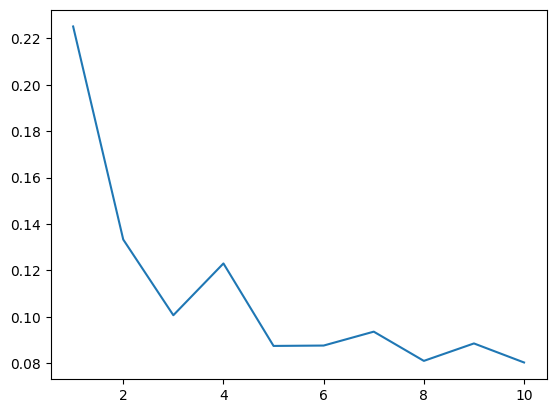

In [8]:
plt.plot(range(1,num_epochs+1),per_epoch_loss_list) 

In [9]:
batch_norm_layer = None
for module in model.modules():
    if isinstance(module, torch.nn.BatchNorm2d):
        batch_norm_layer = module
        print(batch_norm_layer.bias.data)
        print(batch_norm_layer.weight.data)

tensor([-0.5184, -0.1310, -0.1789,  0.2041,  0.1765,  0.1024, -0.1406,  0.3607,
        -0.5169, -0.0335,  0.2382, -0.0925, -0.6393, -0.5180, -0.0826, -0.5876])
tensor([ 0.0700,  0.0207,  0.0306,  1.2104,  0.5201,  0.7277, -0.0401,  0.5854,
         0.5259, -0.0274,  0.5205,  0.2238,  0.3784,  0.5560,  0.0050,  0.1145])
tensor([-1.5115,  0.0247, -0.3800, -0.1993, -0.1652, -0.3541, -0.2444, -0.7377,
         0.1148, -0.3654, -0.4536, -0.1595, -0.7517, -0.6042, -0.3974, -0.2441])
tensor([ 0.6143,  0.3111,  0.0711,  0.4326,  0.8239,  0.2183, -0.1036, -0.0045,
         0.5096,  0.1232,  0.0308,  0.3324,  0.0199,  0.0102, -0.1018,  0.3699])
